In [1]:
%matplotlib inline

In [2]:
from gpitch.matern12_spectral_mixture import MercerMatern12sm
from gpitch.myplots import plot_predict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpitch
import gpflow

In [3]:
# gpu usage
gpitch.init_settings();

In [4]:
def per_fun(xin, npartials, freq):
    """Function to generate sum os sines"""
    f = np.zeros(xin.shape)
    for i in range(npartials):
        f += np.sin(2 * np.pi * xin * (i+1) * freq)
    return f/np.max(np.abs(f))

In [5]:
# generate data
n = 16000  # number of samples
fs = 16000  # sample frequency
x = np.linspace(0., (n-1.)/fs, n).reshape(-1, 1)
component = per_fun(xin=x, npartials=3, freq=15.)
envelope = np.exp(-25 * (x - 0.33) ** 2) + np.exp(-75 * (x - 0.66) ** 2)
envelope /= np.max(np.abs(envelope))
noise_var = 0.000001
y = component * envelope + np.sqrt(noise_var) * np.random.randn(component.size, 1)

In [6]:
#  use maxima as inducing points
z, u = gpitch.init_liv(x=x, y=y, win_size=31, thres=0.05, dec=1)
print("number of inducing variables {0}".format(u.size))

number of inducing variables 76


In [7]:
# init kernels
kact = gpflow.kernels.Matern32(input_dim=1, lengthscales=1.0, variance=1.0)
enr = np.array([1., 1., 1.])
frq = np.array([15., 30., 45.])
kcom = MercerMatern12sm(input_dim=1, energy=enr, frequency=frq)
kern = [[kact], [kcom]]

In [8]:
# init model
m = gpitch.pdgp.Pdgp(x=x.copy(), y=y.copy(), z=z, kern=kern, minibatch_size=100)
m.za.fixed = True
m.zc.fixed = True

In [9]:
# optimization
method = tf.train.AdamOptimizer(learning_rate=0.0025)
m.optimize(method=method, maxiter=2000)

     fun: -23791.217920660958
     jac: array([ -2.71244082e+02,  -6.72929246e+02,   4.42659091e+01, ...,
        -3.79901791e-02,   1.72254501e-02,  -1.62815681e-01])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([-0.27506024,  0.56428382,  1.37246933, ...,  0.01046306,
       -0.38279903,  0.25793468])

In [10]:
# predict
xtest = x[::4].copy()
mu_a, var_a, mu_c, var_c, m_src = m.predict_act_n_com(xtest)

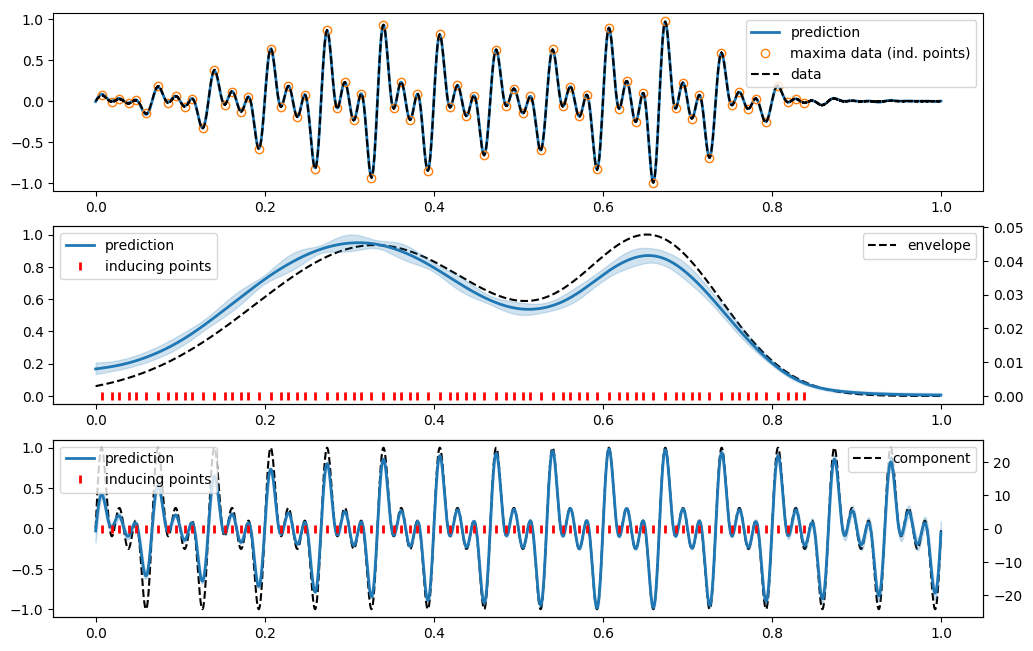

In [11]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(xtest, m_src[0], lw=2)
plt.plot(z[0][0], u, 'o', mfc="none", ms=6, mew=1)
plt.plot(x, y, 'k--')
plt.legend(['prediction', 'maxima data (ind. points)', 'data'])

plt.subplot(3, 1, 2)
plt.plot(x, envelope, 'k--')
plt.legend(['envelope'], loc=1)
plt.twinx()
plot_predict(x=xtest, mean=mu_a[0], var=var_a[0], z=m.za[0].value, latent=True)
plt.legend(['prediction', 'inducing points'], loc=2)

plt.subplot(3, 1, 3)
plt.plot(x, component, 'k--')
plt.legend(['component'], loc=1)
plt.twinx()
plot_predict(x=xtest, mean=mu_c[0], var=var_c[0], z=m.zc[0].value)
plt.legend(['prediction', 'inducing points'], loc=2)
plt.savefig("demo-modgp.png")
plt.show()